# This notebook can be used to reproduce the HD constraints (similarly to Fig. 5 of 2404.02864)

### - Start importing all libraries

In [ ]:
# Global
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf
from fastPTA.signals import get_signal_model
from fastPTA.Fisher_code import compute_fisher

### - Constants to be used in the analysis

In [2]:
# Total observation time in years
T_obs_yrs = 16.03

# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars in the analysis
n_pulsars = 25

# Choose the model for the signal
signal_model = get_signal_model("power_law")

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Parameters for the HD computations:
# Method to compute the HD, either "Legendre" or "Binned"
HD_basis = "Legendre"

# Maximum order of the Legendre polynomials
HD_order = 5

# Whether to add some gaussian prior for the HD coefficients to the Fisher matrix
add_HD_prior = True

# Specify the type of noise to be used in the analysis
which_experiment = eu.EPTAlike

# Number of points to generate for the Fisher
len_fisher_data = int(1e4)

# Where to store the pulsar catalog
outname = "pulsar_configurations/new_EPTAlike_catalog.txt"

### - Set the inputs for the Fisher

In [3]:
# Assemble the vector with two signal parameters
signal_parameters = np.array([log_amplitude, tilt])

# Length of the parameter vector
parameter_len = (
    len(signal_parameters) + HD_order + 1
    if HD_order
    else len(signal_parameters)
)

# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": True,
    "outname" : outname,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "HD_order": HD_order,
    "HD_basis": HD_basis,
    "regenerate_catalog": True,
    "path_to_pulsar_catalog": outname,
}

# Dictionary with the kwargs to generate the fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": signal_parameters,
}

### - Compute the Fisher

In [4]:
(
    frequency,
    signal,
    HD_functions_IJ,
    HD_coeffs,
    effective_noise,
    SNR,
    fisher,
) = compute_fisher(
    **fisher_kwargs,
    get_tensors_kwargs=get_tensors_kwargs,
    generate_catalog_kwargs=generate_catalog_kwargs,
)

pulsar_configurations/new_EPTAlike_catalog.txt


### - Generate some data from the Fisher (and reject with prior) 

In [5]:
# Get the length of the signal parameters
len_signal = len(signal_parameters)

# Compute the covariance matrix
covariance = ut.compute_inverse(fisher)

# Generate the Fisher data
fisher_data = np.random.multivariate_normal(
    np.append(signal_parameters, HD_coeffs),
    covariance,
    size=len_fisher_data,
)

# If add_HD_prior, drop points that are outside the prior
if add_HD_prior:
    fisher_data = fisher_data[
        np.any(fisher_data[:, len_signal:] > -1, axis=1)
        & np.any(fisher_data[:, len_signal:] < 1, axis=1)
    ]

### - Plot the results

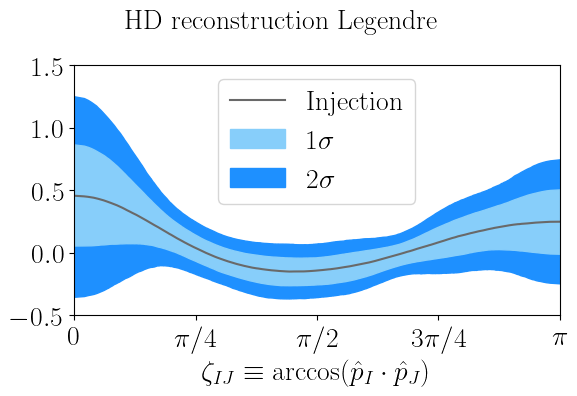

In [6]:
# Plot the results
if get_tensors_kwargs["HD_basis"].lower() == "legendre":
    pf.plot_HD_Legendre(
        1000,
        fisher_data[:, len_signal:],
        r"$\rm HD \ reconstruction \ Legendre$",
    )
    plt.ylim(-0.5, 1.5)

elif get_tensors_kwargs["HD_basis"].lower() == "binned":
    pf.plot_HD_binned(
        fisher_data[:, len_signal:],
        HD_coeffs,
        r"$\rm HD \ reconstruction \ binned$",
    )
    plt.ylim(-1.0, 1.0)

else:
    raise ValueError("Cannot use that")

plt.savefig('plots/HD_reconstruction.png')